<a href="https://colab.research.google.com/github/BarchilhaMateus/Quant-Finance-Studies-/blob/main/BlackLitterman.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import yfinance as yf
import pandas as pd

# Lista dos tickers
tickers = [
     'CRFB3.SA', 'SUZB3.SA', 'STBP3.SA', 'RAIL3.SA',
    'RRRP3.SA', 'BBSE3.SA', 'ITUB4.SA', 'COGN3.SA', 'WEGE3.SA',
    'YDUQ3.SA', 'SLCE3.SA', 'LREN3.SA', 'IRBR3.SA', 'CSNA3.SA',
    'VALE3.SA', 'ELET3.SA', 'CCRO3.SA', 'FLRY3.SA', 'GGBR4.SA',
    'EQTL3.SA', 'PETR4.SA', 'LWSA3.SA', 'NTCO3.SA', 'RADL3.SA',
]

# Datas de início e fim
start_date = "2020-01-01"
end_date = "2024-02-07"

# Lista para armazenar os DataFrames
dataframes = []

# Loop pelos tickers
for ticker in tickers:
    # Download dos dados diários
    daily_data = yf.download(ticker, start=start_date, end=end_date, interval="1d")
    # Adicionar uma coluna para o ticker
    daily_data['Ticker'] = ticker
    # Anexar ao DataFrame na lista
    dataframes.append(daily_data)

# Concatenar todos os DataFrames na lista
stock_data_daily = pd.concat(dataframes)

# Limpar a lista para reutilização
dataframes.clear()

# Handling NaNs
stock_data_daily.dropna(inplace=True)

# check
if stock_data_daily.isnull().any().any():
    print("Existem valores NA")
else:
    print("DataFrame pode ser salvo.")

# Salvar dados
stock_data_daily.to_csv('DadosAções.csv', index=True)



/usr/local/lib/python3.10/dist-packages/yfinance/base.py:48: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  _empty_series = pd.Series()
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1

DataFrame is ready to be saved.


In [2]:
import numpy as np

stock_data_daily['Historical Return'] = stock_data_daily.groupby('Ticker')['Adj Close'].transform(lambda x: np.log(x / x.shift(1))) #Retornos logaritmicos

In [3]:
stock_data_daily.tail()

,Open,High,Low,Close,Adj Close,Volume,Ticker,Historical Return
Date,,,,,,,,
2024-01-31,25.950001,26.040001,25.170000,25.299999,25.299999,26642900,RADL3.SA,-0.036862
2024-02-01,25.219999,25.350000,24.950001,25.120001,25.120001,9930200,RADL3.SA,-0.007140
2024-02-02,25.040001,25.160000,24.629999,24.860001,24.860001,10577900,RADL3.SA,-0.010404
2024-02-05,24.750000,24.820000,24.299999,24.459999,24.459999,10037100,RADL3.SA,-0.016221
2024-02-06,24.459999,25.250000,24.370001,25.150000,25.150000,22494300,RADL3.SA,0.027819


In [4]:
stock_data_daily.isnull().sum() #checar valores nulos

Open                  0
High                  0
Low                   0
Close                 0
Adj Close             0
Volume                0
Ticker                0
Historical Return    24
dtype: int64

In [5]:
# dropar valores nulos
stock_data_daily.dropna(inplace=True)

In [6]:
stock_data_daily.isnull().sum()

Open                 0
High                 0
Low                  0
Close                0
Adj Close            0
Volume               0
Ticker               0
Historical Return    0
dtype: int64

In [7]:
mcaps = {}
for t in tickers:
    stock = yf.Ticker(t)
    mcaps[t] = stock.info["marketCap"]
mcaps


# Calcular market cap de cada ticker
total_market_cap = sum(mcaps.values())

# market cap ponderado
market_cap_weights = {ticker: cap / total_market_cap for ticker, cap in mcaps.items()}

# inserir no dataframe
stock_data_daily['Market Cap Weight'] = stock_data_daily['Ticker'].map(market_cap_weights)

In [8]:
# Remover NaNs criados pela operação shift
stock_data_daily.dropna(inplace=True)

In [9]:
stock_data_daily.isnull().sum() #checar valores nulos

Open                 0
High                 0
Low                  0
Close                0
Adj Close            0
Volume               0
Ticker               0
Historical Return    0
Market Cap Weight    0
dtype: int64

In [10]:
#market equlibrium returns
pi = stock_data_daily['Market Cap Weight'] * stock_data_daily['Historical Return']

pi

Date
2020-01-03    0.000346
2020-01-06   -0.000602
2020-01-07   -0.000081
2020-01-08   -0.000257
2020-01-09    0.000292
                ...   
2024-01-31   -0.000876
2024-02-01   -0.000170
2024-02-02   -0.000247
2024-02-05   -0.000385
2024-02-06    0.000661
Length: 24191, dtype: float64

In [11]:
pip install PyPortfolioOpt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.9/61.9 kB 2.2 MB/s eta 0:00:00


In [12]:
from pypfopt import black_litterman, risk_models
from pypfopt import BlackLittermanModel, plotting
from pypfopt import DiscreteAllocation

In [13]:
# baixar apenas o retorno

returns = yf.download(tickers, start_date, end_date)['Adj Close']

[*********************100%%**********************]  24 of 24 completed


In [14]:
returns.dropna(inplace=True)

In [15]:
returns.isnull().sum()

Ticker
BBSE3.SA    0
CCRO3.SA    0
COGN3.SA    0
CRFB3.SA    0
CSNA3.SA    0
ELET3.SA    0
EQTL3.SA    0
FLRY3.SA    0
GGBR4.SA    0
IRBR3.SA    0
ITUB4.SA    0
LREN3.SA    0
LWSA3.SA    0
NTCO3.SA    0
PETR4.SA    0
RADL3.SA    0
RAIL3.SA    0
RRRP3.SA    0
SLCE3.SA    0
STBP3.SA    0
SUZB3.SA    0
VALE3.SA    0
WEGE3.SA    0
YDUQ3.SA    0
dtype: int64

In [16]:
#Ibovespa Benchmark
market_prices = yf.download("^BVSP", start="2020-01-01", end="2024-01-30")["Adj Close"]
market_prices.head()


[*********************100%%**********************]  1 of 1 completed


Date
2020-01-02    118573.0
2020-01-03    117707.0
2020-01-06    116878.0
2020-01-07    116662.0
2020-01-08    116247.0
Name: Adj Close, dtype: float64

In [17]:
Sigma = risk_models.CovarianceShrinkage(returns).ledoit_wolf()
delta = black_litterman.market_implied_risk_aversion(market_prices)

In [18]:
Sigma

Ticker,BBSE3.SA,CCRO3.SA,COGN3.SA,CRFB3.SA,CSNA3.SA,ELET3.SA,EQTL3.SA,FLRY3.SA,GGBR4.SA,IRBR3.SA,...,PETR4.SA,RADL3.SA,RAIL3.SA,RRRP3.SA,SLCE3.SA,STBP3.SA,SUZB3.SA,VALE3.SA,WEGE3.SA,YDUQ3.SA
Ticker,,,,,,,,,,,,,,,,,,,,,
BBSE3.SA,0.055630,0.023142,0.027645,0.021583,0.019678,0.029361,0.019117,0.024532,0.016376,0.027380,...,0.021460,0.019573,0.019450,0.020097,0.013023,0.027645,0.002067,0.008505,0.020891,0.030480
CCRO3.SA,0.023142,0.100086,0.073967,0.040272,0.034971,0.049016,0.036547,0.038408,0.022390,0.049173,...,0.037978,0.032443,0.051924,0.034910,0.016184,0.063550,-0.000112,0.010243,0.029901,0.073266
COGN3.SA,0.027645,0.073967,0.255842,0.061393,0.052368,0.071597,0.046821,0.068906,0.030654,0.089024,...,0.042752,0.053271,0.061977,0.046269,0.016393,0.099231,-0.009350,0.016113,0.035405,0.191550
CRFB3.SA,0.021583,0.040272,0.061393,0.147087,0.040657,0.048894,0.032919,0.037537,0.027475,0.045880,...,0.027130,0.039794,0.043055,0.044668,0.020879,0.044327,0.013793,0.020223,0.030740,0.073690
CSNA3.SA,0.019678,0.034971,0.052368,0.040657,0.240005,0.038145,0.019655,0.019347,0.121290,0.048855,...,0.052721,0.017697,0.039079,0.081166,0.048053,0.042676,0.037866,0.116671,0.036213,0.059093
ELET3.SA,0.029361,0.049016,0.071597,0.048894,0.038145,0.128033,0.047248,0.042412,0.025868,0.054410,...,0.041526,0.029985,0.043049,0.041795,0.015290,0.059765,-0.002763,0.014824,0.034389,0.076468
EQTL3.SA,0.019117,0.036547,0.046821,0.032919,0.019655,0.047248,0.068844,0.036649,0.016815,0.036519,...,0.019581,0.026374,0.033691,0.029075,0.015700,0.041269,-0.000361,0.005213,0.026377,0.049142
FLRY3.SA,0.024532,0.038408,0.068906,0.037537,0.019347,0.042412,0.036649,0.105360,0.013318,0.042769,...,0.021406,0.037638,0.034032,0.023343,0.015757,0.049196,0.003959,0.002057,0.035619,0.073678
GGBR4.SA,0.016376,0.022390,0.030654,0.027475,0.121290,0.025868,0.016815,0.013318,0.126181,0.031156,...,0.039836,0.010053,0.023258,0.051875,0.031558,0.025346,0.033332,0.076615,0.031857,0.034509


<Axes: xlabel='Ticker', ylabel='Ticker'>

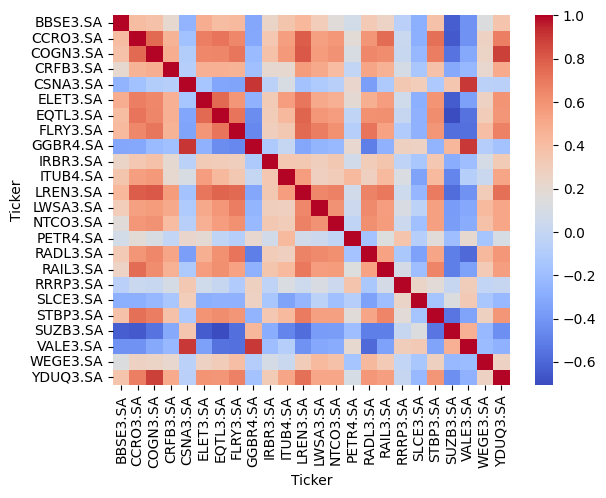

In [19]:
import seaborn as sns
#Visualizar Matriz Correlação
sns.heatmap(Sigma.corr(), cmap='coolwarm')

In [20]:
market_prior = black_litterman.market_implied_prior_returns(mcaps, delta, Sigma)


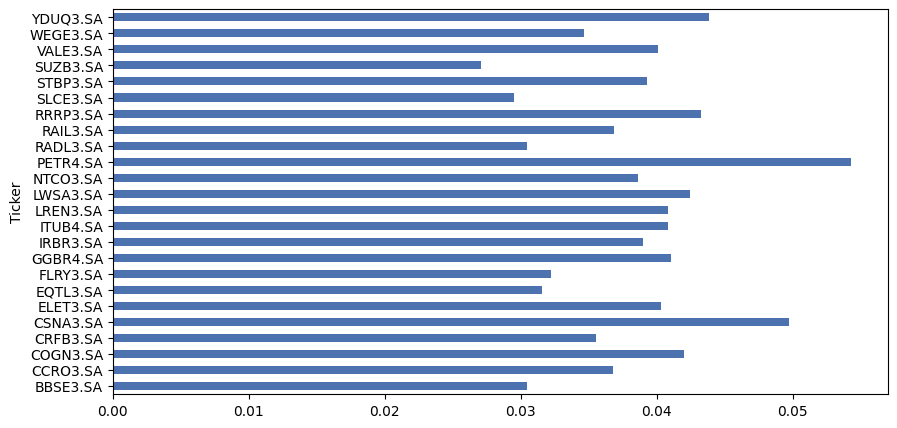

In [21]:
#O quanto vamos ser compensado pelo risco
market_prior.plot.barh(figsize=(10,5));

In [23]:
import numpy as np

Q_dict = {
    'CRFB3.SA': 0.21, 'SUZB3.SA': 0.10, 'STBP3.SA': 0.02, 'RAIL3.SA': 0.11,
    'RRRP3.SA': 0.5, 'BBSE3.SA': 0.15, 'ITUB4.SA': 0.09, 'COGN3.SA': -0.1, 'WEGE3.SA': 0.34,
    'YDUQ3.SA': 0.04, 'SLCE3.SA': 0.5, 'LREN3.SA': 0.06, 'IRBR3.SA': 0.08, 'CSNA3.SA': -0.2,
    'VALE3.SA': 0.02, 'ELET3.SA': 0.14, 'CCRO3.SA': 0.04, 'FLRY3.SA': 0.19, 'GGBR4.SA': 0.18,
    'EQTL3.SA': 0.06, 'PETR4.SA': -0.08, 'LWSA3.SA': -0.03, 'NTCO3.SA': -0.07, 'RADL3.SA': -0.6,
}

# Filter out None values
filtered_Q_dict = {k: v for k, v in Q_dict.items() if v is not None}

# Extract keys and values to create the P matrix
assets = list(filtered_Q_dict.keys())
views = list(filtered_Q_dict.values())

Q = np.array(views)  # This assumes views are in the order you wish to maintain

# Ensure Q is a column vector
Q = Q.reshape(-1, 1)

Q

array([[ 0.21],
       [ 0.1 ],
       [ 0.02],
       [ 0.11],
       [ 0.5 ],
       [ 0.15],
       [ 0.09],
       [-0.1 ],
       [ 0.34],
       [ 0.04],
       [ 0.5 ],
       [ 0.06],
       [ 0.08],
       [-0.2 ],
       [ 0.02],
       [ 0.14],
       [ 0.04],
       [ 0.19],
       [ 0.18],
       [ 0.06],
       [-0.08],
       [-0.03],
       [-0.07],
       [-0.6 ]])

In [24]:
bl = BlackLittermanModel(Sigma, pi=market_prior, absolute_views=Q_dict)

In [25]:
import numpy as np

num_assets = 24 # Number of stocks in the portfolio
num_views = 5    # Number of different views you want to simulate
num_simulations = 100  # Total number of simulations

# Generate one example P matrix
P_example = np.zeros((num_views, num_assets))

for view in range(num_views):
    # Randomly decide the number of assets involved in this view
    assets_involved = np.random.choice(num_assets, size=np.random.randint(1, num_assets+1), replace=False)

    # Assign random weights to these assets
    weights = np.random.uniform(-1, 1, size=len(assets_involved))  # Uniform distribution, can be adjusted
    weights /= np.sum(np.abs(weights))  # Normalize weights to sum to 1 in absolute value for this view

    # Populate the P matrix for this view
    P_example[view, assets_involved] = weights

# Print one example P matrix
print("Example P Matrix:\n", P_example)


Example P Matrix:
 [[ 0.          0.17574064  0.          0.          0.10535613  0.0452243
   0.          0.         -0.03910541  0.18781412  0.08798026  0.00280723
   0.          0.          0.          0.          0.          0.05660442
   0.         -0.00281414  0.          0.          0.08976192  0.20679144]
 [ 0.02188975  0.         -0.05088873 -0.00679219  0.08188121 -0.03246544
   0.          0.01370532 -0.07807674  0.10813163  0.11145007  0.0179252
   0.09432773  0.0694182  -0.00304616  0.         -0.00786884  0.
  -0.06304757 -0.0869177   0.05146528  0.10070224  0.          0.        ]
 [ 0.         -0.11894363 -0.06397612 -0.12483267 -0.06089958  0.
   0.11949901  0.          0.01434507  0.0064664  -0.10507749  0.11828306
   0.01804851 -0.08624772  0.          0.          0.          0.
   0.0298727   0.04785215 -0.08513712  0.00051877  0.          0.        ]
 [ 0.          0.          0.         -0.09855682  0.          0.
  -0.01885318  0.03438244  0.          0.         

In [26]:
import numpy as np

# Assuming the corrected list of intervals for 24 assets
intervals = [
    (0, 0.25), (0.1, 0.4), (-0.1, 0.15), (-0.05, 0.1), (0.15, 0.25),
    (-0.1, 0), (0.1, 0.2), (0.08, 0.12), (0.1, 0.9), (0, 0.3),
    (0, 0.25), (0.1, 0.4), (-0.1, 0.15), (-0.05, 0.1), (0.15, 0.25),
    (-0.1, 0), (0.1, 0.2), (0.08, 0.12), (0.1, 0.9), (0, 0.3), (0, 0.2),
    # Placeholder for missing intervals to make up 24
    (0.05, 0.2), (0.02, 0.18), (0.03, 0.25)
]

# Calculate midpoints for Q
Q = np.array([(upper + lower) / 2 for lower, upper in intervals])

# P as an identity matrix for 24 assets
P = np.eye(24)

# Calculate variances based on intervals and construct Omega
variances = [((upper - lower) / 2)**2 for lower, upper in intervals]
Omega = np.diag(variances)


In [27]:
# We are using the shortcut to automatically compute market-implied prior
bl = BlackLittermanModel(Sigma, pi="market", market_caps=mcaps, risk_aversion=delta,
                        absolute_views=Q_dict, omega=Omega)

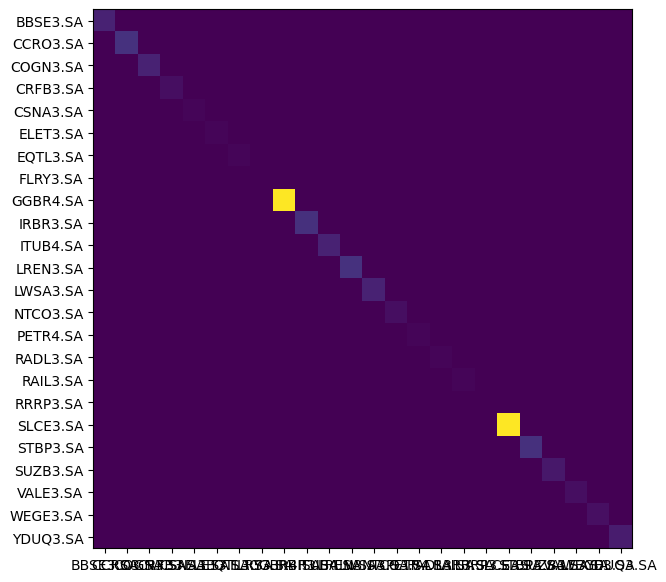

In [28]:
import matplotlib.pyplot as plt
import plotly.express as px

fig, ax = plt.subplots(figsize=(7,7))
im = ax.imshow(Omega)

# We want to show all ticks...
ax.set_xticks(np.arange(len(bl.tickers)))
ax.set_yticks(np.arange(len(bl.tickers)))

ax.set_xticklabels(bl.tickers)
ax.set_yticklabels(bl.tickers)
plt.show()

In [29]:
# Posterior estimate of returns
ret_bl = bl.bl_returns()
ret_bl

Ticker
BBSE3.SA    0.097549
CCRO3.SA    0.041522
COGN3.SA   -0.092402
CRFB3.SA    0.091107
CSNA3.SA   -0.060456
ELET3.SA    0.115891
EQTL3.SA    0.078681
FLRY3.SA    0.172095
GGBR4.SA    0.022905
IRBR3.SA    0.049098
ITUB4.SA    0.063396
LREN3.SA    0.068553
LWSA3.SA    0.003863
NTCO3.SA   -0.037878
PETR4.SA    0.050557
RADL3.SA   -0.074973
RAIL3.SA    0.068470
RRRP3.SA    0.410890
SLCE3.SA    0.175605
STBP3.SA    0.061747
SUZB3.SA    0.034332
VALE3.SA    0.014685
WEGE3.SA    0.063464
YDUQ3.SA   -0.001576
dtype: float64

In [30]:
rets_df = pd.DataFrame([market_prior, ret_bl, pd.Series(Q_dict)],
             index=["Prior", "Posterior", "Views"]).T
rets_df

,Prior,Posterior,Views
BBSE3.SA,0.030419,0.097549,0.15
CCRO3.SA,0.036808,0.041522,0.04
COGN3.SA,0.042005,-0.092402,-0.10
CRFB3.SA,0.035551,0.091107,0.21
CSNA3.SA,0.049687,-0.060456,-0.20
ELET3.SA,0.040334,0.115891,0.14
EQTL3.SA,0.031564,0.078681,0.06
FLRY3.SA,0.032235,0.172095,0.19
GGBR4.SA,0.041054,0.022905,0.18
IRBR3.SA,0.039010,0.049098,0.08


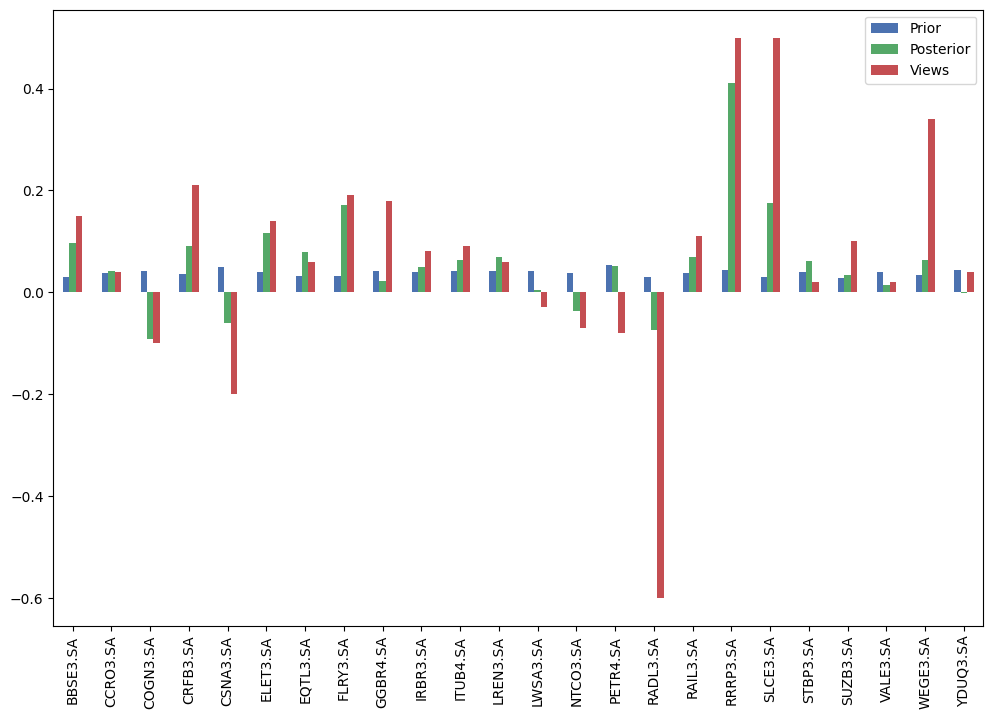

In [31]:
rets_df.plot.bar(figsize=(12,8));

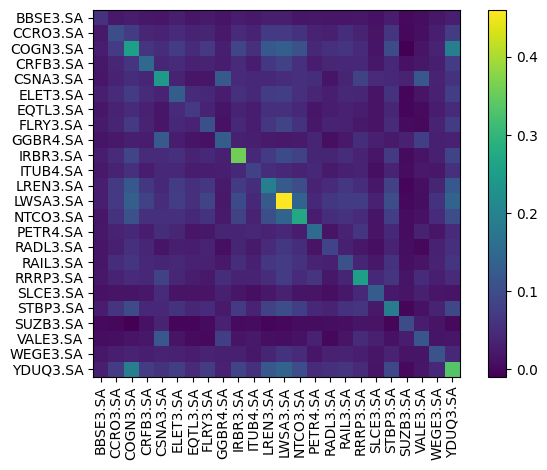

In [32]:
S_bl = bl.bl_cov()
plotting.plot_covariance(S_bl);

In [33]:
from pypfopt import EfficientFrontier, objective_functions

ef = EfficientFrontier(ret_bl, S_bl)
ef.add_objective(objective_functions.L2_reg)
ef.max_sharpe()
weights = ef.clean_weights()
weights

/usr/local/lib/python3.10/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  warnings.warn(


OrderedDict([('BBSE3.SA', 0.07322),
             ('CCRO3.SA', 0.0),
             ('COGN3.SA', 0.0),
             ('CRFB3.SA', 0.0461),
             ('CSNA3.SA', 0.0),
             ('ELET3.SA', 0.07515),
             ('EQTL3.SA', 0.04204),
             ('FLRY3.SA', 0.15083),
             ('GGBR4.SA', 0.0),
             ('IRBR3.SA', 0.0),
             ('ITUB4.SA', 0.02423),
             ('LREN3.SA', 0.00989),
             ('LWSA3.SA', 0.0),
             ('NTCO3.SA', 0.0),
             ('PETR4.SA', 0.0),
             ('RADL3.SA', 0.0),
             ('RAIL3.SA', 0.02416),
             ('RRRP3.SA', 0.37032),
             ('SLCE3.SA', 0.15101),
             ('STBP3.SA', 0.00325),
             ('SUZB3.SA', 0.00646),
             ('VALE3.SA', 0.0),
             ('WEGE3.SA', 0.02335),
             ('YDUQ3.SA', 0.0)])

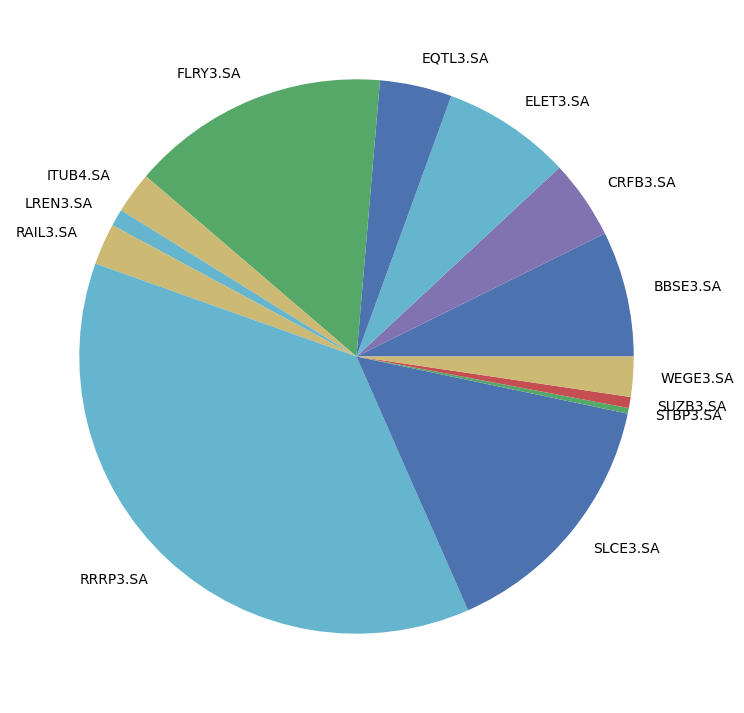

In [34]:
pd.Series(weights).plot.pie(figsize=(9,9));

/usr/local/lib/python3.10/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  warnings.warn(


Expected annual return: 23.4%
Annual volatility: 25.8%
Sharpe Ratio: 0.83


/usr/local/lib/python3.10/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:441: UserWarning: The risk_free_rate provided to portfolio_performance is different to the one used by max_sharpe. Using the previous value.
  warnings.warn(


(0.2337692054037837, 0.2578219704709289, 0.8291349453784722)

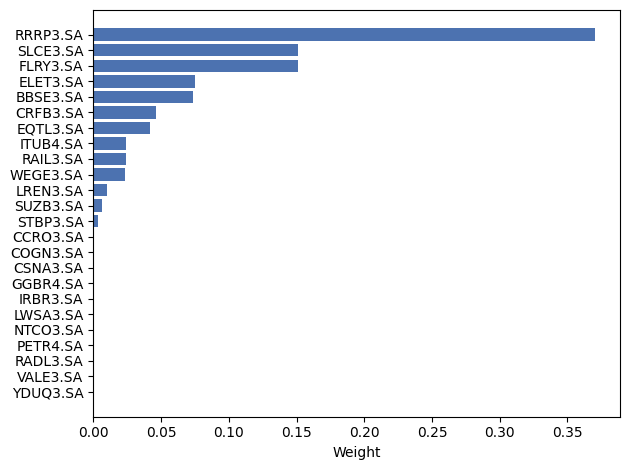

In [35]:
from pypfopt.plotting import plot_weights

# Maximum Sharpe
ef = EfficientFrontier(ret_bl, S_bl)
ef.add_objective(objective_functions.L2_reg)
ef.max_sharpe()
weights = ef.clean_weights()

plot_weights(weights)
ef.portfolio_performance(verbose = True, risk_free_rate = 0.01125)

In [36]:
import numpy as np

def idzorek_method(view_confidences, cov_matrix, pi, Q, P, tau, risk_aversion=1):
    """
    Calculate the uncertainty matrix Omega using Idzorek's method.
    """
    # Ensure inputs are numpy arrays for matrix operations
    view_confidences = np.array(intervals)
    assert 0 <= view_confidences.all() <= 1, "Confidences must be between 0 and 1"

    # Calculate the proportional uncertainty
    proportional_uncertainty = 1 / np.sqrt(view_confidences)

    # Calculate the Black-Litterman master formula components
    omega_diag = np.diag(np.diag(P @ (cov_matrix * tau) @ P.T))

    # Adjust omega by the proportional uncertainty derived from user confidence
    Omega = omega_diag * proportional_uncertainty**2

    return Omega


In [37]:
# We are using the shortcut to automatically compute market-implied prior
bl = BlackLittermanModel(Sigma, pi="market", market_caps=mcaps, risk_aversion=delta,
                        absolute_views=Q_dict, omega=Omega)

In [38]:
# Posterior estimate of returns
ret_bl = bl.bl_returns()
ret_bl

Ticker
BBSE3.SA    0.097549
CCRO3.SA    0.041522
COGN3.SA   -0.092402
CRFB3.SA    0.091107
CSNA3.SA   -0.060456
ELET3.SA    0.115891
EQTL3.SA    0.078681
FLRY3.SA    0.172095
GGBR4.SA    0.022905
IRBR3.SA    0.049098
ITUB4.SA    0.063396
LREN3.SA    0.068553
LWSA3.SA    0.003863
NTCO3.SA   -0.037878
PETR4.SA    0.050557
RADL3.SA   -0.074973
RAIL3.SA    0.068470
RRRP3.SA    0.410890
SLCE3.SA    0.175605
STBP3.SA    0.061747
SUZB3.SA    0.034332
VALE3.SA    0.014685
WEGE3.SA    0.063464
YDUQ3.SA   -0.001576
dtype: float64

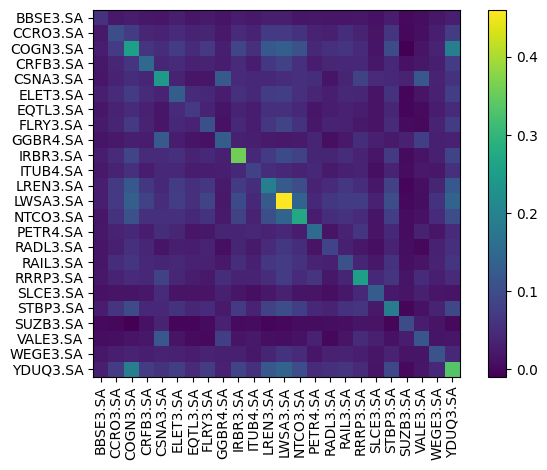

In [39]:
S_bl = bl.bl_cov()
plotting.plot_covariance(S_bl);

In [40]:
from pypfopt import EfficientFrontier, objective_functions

ef = EfficientFrontier(ret_bl, S_bl)
ef.add_objective(objective_functions.L2_reg)
ef.max_sharpe()
weights = ef.clean_weights()
weights

/usr/local/lib/python3.10/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  warnings.warn(


OrderedDict([('BBSE3.SA', 0.07322),
             ('CCRO3.SA', 0.0),
             ('COGN3.SA', 0.0),
             ('CRFB3.SA', 0.0461),
             ('CSNA3.SA', 0.0),
             ('ELET3.SA', 0.07515),
             ('EQTL3.SA', 0.04204),
             ('FLRY3.SA', 0.15083),
             ('GGBR4.SA', 0.0),
             ('IRBR3.SA', 0.0),
             ('ITUB4.SA', 0.02423),
             ('LREN3.SA', 0.00989),
             ('LWSA3.SA', 0.0),
             ('NTCO3.SA', 0.0),
             ('PETR4.SA', 0.0),
             ('RADL3.SA', 0.0),
             ('RAIL3.SA', 0.02416),
             ('RRRP3.SA', 0.37032),
             ('SLCE3.SA', 0.15101),
             ('STBP3.SA', 0.00325),
             ('SUZB3.SA', 0.00646),
             ('VALE3.SA', 0.0),
             ('WEGE3.SA', 0.02335),
             ('YDUQ3.SA', 0.0)])

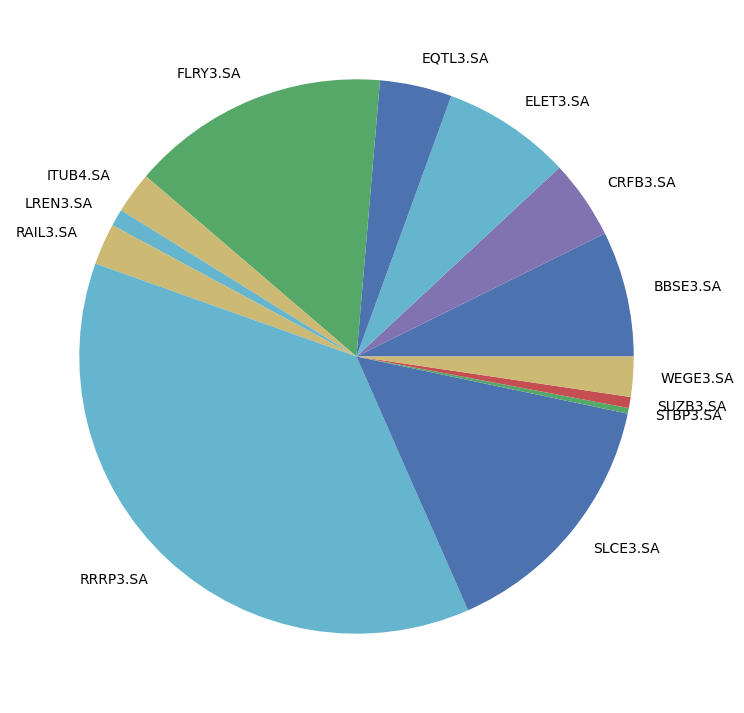

In [41]:
pd.Series(weights).plot.pie(figsize=(9,9));

Expected annual return: 23.4%
Annual volatility: 25.8%
Sharpe Ratio: 0.83


/usr/local/lib/python3.10/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:259: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/pypfopt/efficient_frontier/efficient_frontier.py:441: UserWarning: The risk_free_rate provided to portfolio_performance is different to the one used by max_sharpe. Using the previous value.
  warnings.warn(


(0.2337692054037837, 0.2578219704709289, 0.8291349453784722)

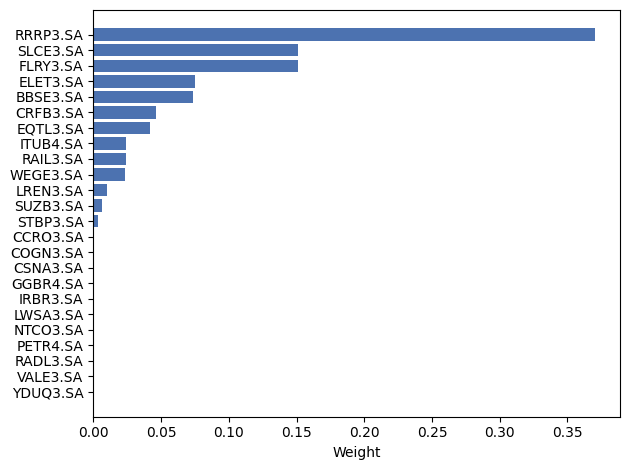

In [42]:
from pypfopt.plotting import plot_weights

# Maximum Sharpe
ef = EfficientFrontier(ret_bl, S_bl)
ef.add_objective(objective_functions.L2_reg)
ef.max_sharpe()
weights = ef.clean_weights()

plot_weights(weights)
ef.portfolio_performance(verbose = True, risk_free_rate = 0.01125)

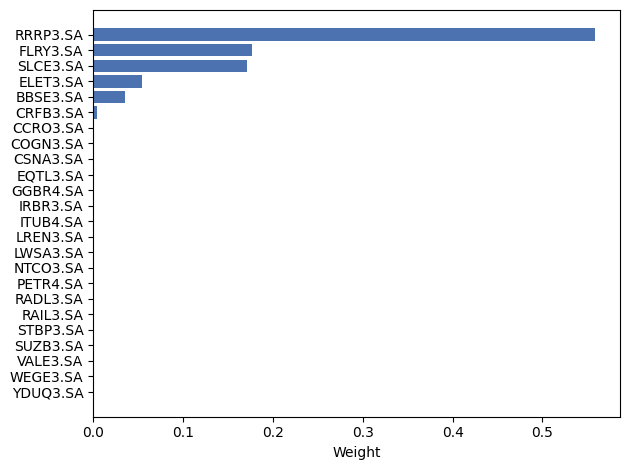

Expected annual return: 30.0%
Annual volatility: 32.6%
Sharpe Ratio: 0.89


(0.3, 0.3259991790044407, 0.8857384269549547)

In [43]:
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import objective_functions, plotting
import matplotlib.pyplot as plt

# Define your target return
target_return = 0.30  # For example, a target return of 10%

# Initialize the Efficient Frontier object
ef = EfficientFrontier(ret_bl, S_bl)

# Optionally, add regularization to reduce overfitting and improve out-of-sample performance
ef.add_objective(objective_functions.L2_reg)

# Minimize semideviation for the given target return
ef.efficient_return(target_return=target_return, market_neutral=False)

# Clean the weights to make them more interpretable
weights = ef.clean_weights()

# Plot the weights of the portfolio
plotting.plot_weights(weights)
plt.show()

# Display the expected performance of the portfolio
ef.portfolio_performance(verbose=True, risk_free_rate=0.01125)


In [44]:
from pypfopt.discrete_allocation import DiscreteAllocation, get_latest_prices

latest_prices = get_latest_prices(returns)
da = DiscreteAllocation(weights, latest_prices, total_portfolio_value=10000)
allocation, leftover = da.lp_portfolio()
print("Allocation:", allocation)
print("Funds remaining: ${:.2f}".format(leftover))


Allocation: {'BBSE3.SA': 11, 'COGN3.SA': 1, 'CRFB3.SA': 4, 'ELET3.SA': 12, 'FLRY3.SA': 106, 'RRRP3.SA': 196, 'SLCE3.SA': 89}
Funds remaining: $1.14


In [ ]:
pip install riskfolio-lib

In [ ]:
weights

In [ ]:
from collections import OrderedDict
import pandas as pd

# Assuming your OrderedDict of weights is named `weights_ordered_dict`
weights_ordered_dict = OrderedDict([('BBSE3.SA', 0.07322),
                                    ('CCRO3.SA', 0.0),
                                    ('COGN3.SA', 0.0),
                                    ('CRFB3.SA', 0.0461),
                                    ('CSNA3.SA', 0.0),
                                    ('ELET3.SA', 0.07515),
                                    ('EQTL3.SA', 0.04203),
                                    ('FLRY3.SA', 0.15084),
                                    ('GGBR4.SA', 0.0),
                                    ('IRBR3.SA', 0.0),
                                    ('ITUB4.SA', 0.02422),
                                    ('LREN3.SA', 0.00988),
                                    ('LWSA3.SA', 0.0),
                                    ('NTCO3.SA', 0.0),
                                    ('PETR4.SA', 0.0),
                                    ('RADL3.SA', 0.0),
                                    ('RAIL3.SA', 0.02416),
                                    ('RRRP3.SA', 0.37033),
                                    ('SLCE3.SA', 0.15101),
                                    ('STBP3.SA', 0.00325),
                                    ('SUZB3.SA', 0.00646),
                                    ('VALE3.SA', 0.0),
                                    ('WEGE3.SA', 0.02334),
                                    ('YDUQ3.SA', 0.0)])

# Transform the OrderedDict into a Pandas Series
weights_series = pd.Series(weights_ordered_dict)

print(weights_series)


In [ ]:
print(stock_data_daily.columns)


In [ ]:
# Reset the index to make the date information a column
stock_data_daily_reset = stock_data_daily.reset_index()

# Print the new column names to verify the correct name for the date column
print(stock_data_daily_reset.columns)


In [ ]:
# Replace 'date' with the actual column name that contains the date information
daily_returns = stock_data_daily_reset.pivot(index='Date', columns='Ticker', values='Close').pct_change()


In [ ]:
import riskfolio as rf


# Calculate portfolio returns
portfolio_returns = (daily_returns * weights_series).sum(axis=1)



# Calculate VaR and CVaR using the correct portfolio returns
alpha = 0.05  # Confidence level

VaR = rf.VaR_Hist(X=portfolio_returns, alpha=alpha)
CVaR = rf.CVaR_Hist(X=portfolio_returns, alpha=alpha)

print(f"Value at Risk (VaR) at {alpha*100}% significance level: {VaR}")
print(f"Conditional Value at Risk (CVaR) at {alpha*100}% significance level: {CVaR}")



Incorporate Alternative Data: Extend the model to include alternative data sources, such as sentiment analysis from news articles or financial reports, as part of the views (Q) matrix.
Dynamic Views Adjustment: Implement a mechanism to dynamically adjust views based on recent market performance or other financial indicators.
Machine Learning Models: Use machine learning models to generate or adjust the views based on historical data and patterns.

SECTION 3.2

In [ ]:
if P_k.shape[1] != Sigma.shape[0]:
    raise ValueError("P_k and Sigma are not compatible for matrix multiplication.")

In [ ]:
lambda_ = delta  # Risk aversion coefficient
tau = 1  # Scalar
C_k = np.array([
    (0, 0.25), (0.1, 0.4), (-0.1, 0.15), (-0.05, 0.1), (0.15, 0.25),
    (-0.1, 0), (0.1, 0.2), (0.08, 0.12), (0.1, 0.9), (0, 0.3),
    (0, 0.25), (0.1, 0.4), (-0.1, 0.15), (-0.05, 0.1), (0.15, 0.25),
    (-0.1, 0), (0.1, 0.2), (0.08, 0.12), (0.1, 0.9), (0, 0.3), (0, 0.2),
    # Placeholder for missing intervals to make up 24
    (0.05, 0.2), (0.02, 0.18), (0.03, 0.25)
])


# For each view, calculate E[R_k100%]
E_R_k100 = []
for k in range(len(Q)):
    P_k = P[k]  # Extract the kth row of P as a row vector
    Q_k = Q[k]
    E_R_k100.append(pi + tau * Sigma @ P_k.T @ np.linalg.inv(P_k @ tau * Sigma @ P_k.T) * (Q_k - P_k @ pi))
E_R_k100 = np.array(E_R_k100).squeeze()

In [ ]:
# Calculate w_k100% for each view
w_k100 = []
for E_R_k in E_R_k100:
    w_k100.append(np.linalg.inv(lambda_ * Sigma) @ E_R_k)
w_k100 = np.array(w_k100)


In [ ]:
# Assume market capitalization weights are given
w_mkt = np.array([...])

# Calculate D_k100% for each view
D_k100 = w_k100 - w_mkt


In [ ]:
# Calculate the tilt for each view
Tilt_k = D_k100 * C_k[:, np.newaxis]  # Assuming C_k is aligned with views


In [ ]:
# Calculate the target weight vector w_k%
w_k_perc = w_mkt + Tilt_k
